# Evaluating gambles

### _An exploration of expected values and time averages_

## General concepts and mandatory coin flipping

We define a _gamble_ $G$ as a set of payouts $D$ associated with a probability distribution $\mathbf{P}$.  

As an example, consider a game where a fair coin is tossed. If heads comes up, you win $\$3$, you lose $\$1$ otherwise.  
Here the gamble has payouts $D = \{3, -1\}$ where $P(d) = 0.5 \, \, \forall \, d \in D$  
Would it be profitable to play such a game?

Our intuition suggests we should take the average of the payouts weighted by their probalility.

In [1]:
weighted_average = 3 * 0.5 + -1 * 0.5
print(weighted_average)

1.0


This number is known as the **expected value** of the game (we also refer to $G$ as a [random variable](https://en.wikipedia.org/wiki/Random_variable)).

What does this number mean? Should we expect to win $\$1$ _every time_ we play? Perhaps it says something about our long term winnigs if we play many times over?

Conceptually, it helps to think about expected values as taking the average of the payouts over many (tending to infinity) plays (_realizations_) of the game.  
Think of $n$ individuals playing simultaneously. We then take the average of their winnings by summing over all the payouts and dividing over $n$.

In [2]:
%config InlineBackend.figure_format="retina"
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-talk")
np.random.seed(42)

In [3]:
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
n = 100

def average_payout(n):
    coin_flips = np.random.rand(n)

    # Heads when > 0.5, Tails when <= 0.5
    payouts = np.where(coin_flips > 0.5, 3, -1)
    
    return payouts.mean()

print(average_payout(n))

0.88


In fact, by the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem#Classical_CLT), as $n$ increases this average will tend towards the expected value.

In [5]:
n = 1_000_000

print(average_payout(n))

1.0021


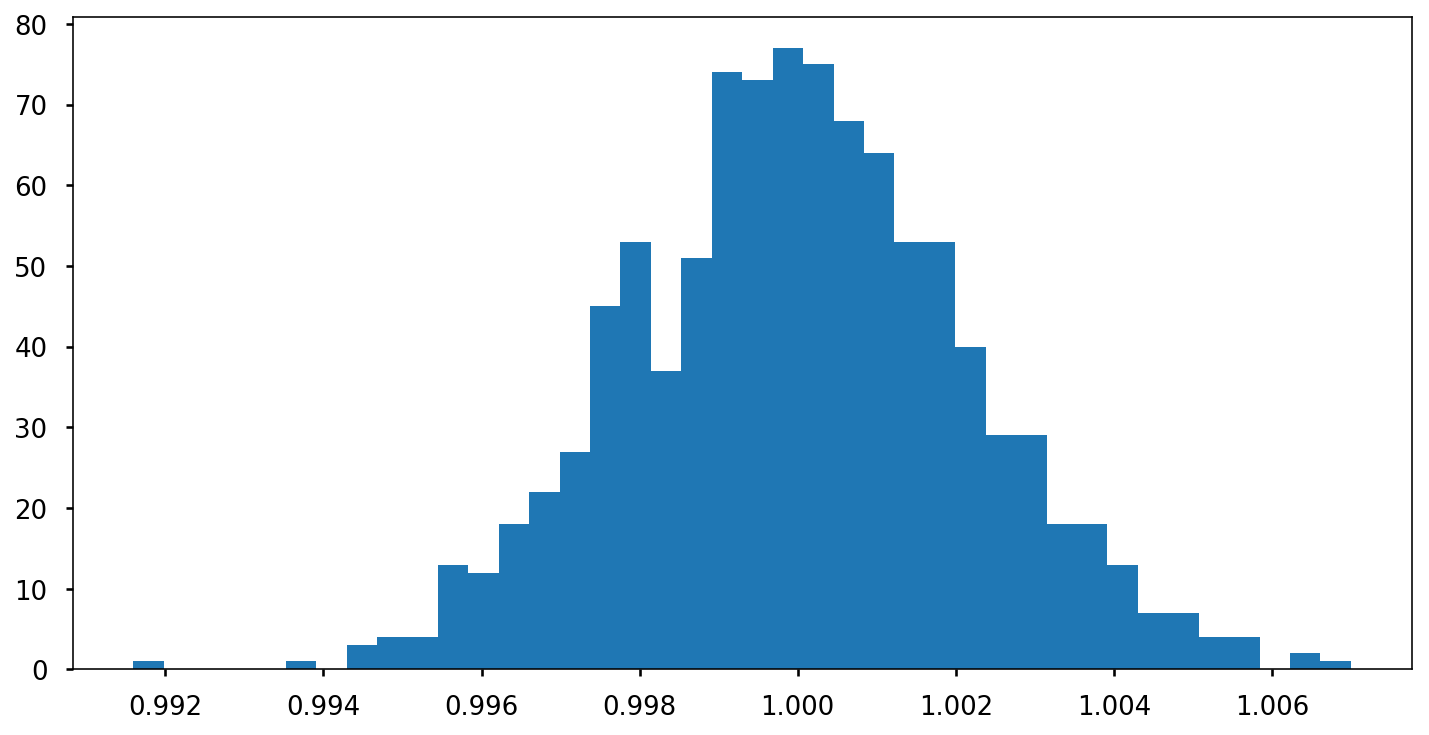

In [6]:
many_payouts = [average_payout(x) for x in np.full(1000, n)]
plt.hist(many_payouts, bins=40);

## Games people play (or avoid)

### Some questions to ponder

- Why do we choose to enter or avoid such gambles?
- Is the expected value telling us all we need to know?
- Is there a criterion that works for every concievable game?

Our intuition suggests we should try to maximise the change in our wealth $\Delta x = x(t + \Delta t) - x(t)$.

However, consider the following [game](https://en.wikipedia.org/wiki/St._Petersburg_paradox):

1. A casino offers a game of chance in which a fair coin is tossed at each stage.
2. The initial stake starts at $\$2$ and is doubled every time heads appears.
3. The first time tails appears, the game ends and the player wins whatever is in the pot.
4.  The player wins $\$2^k$ where $k$ is the number of coin tosses.

What would be a fair price (i.e. a price at which you would feel indifferent taking the role of the gambler or the casino) to play such a game?


The expected value of such a game is

$$\mathbb{E} = \frac{1}{2} \cdot 2 + \frac{1}{4} \cdot 4 + \frac{1}{8} \cdot 8 + \dotsb = 1 + 1 + 1 + \dotsb = \infty$$

Should we be willing to pay any amount for the opportunity to play?  
Most people would not, even though the game has an infinite expected value.

### Expected utility hypothesis

The aforementioned paradox was studied by [Daniel Bernoulli](https://en.wikipedia.org/wiki/Daniel_Bernoulli). He introduced the [expected utility hypothesis](https://en.wikipedia.org/wiki/Expected_utility_hypothesis), which states that individual preferences concerning such gambles aim to maximise not the expected change in wealth, but the **expected change in utility**, which is a mathematical concept that captures the subjective value of wealth to the individual.

**Key points**

- Utility functions could differ between individuals.
- Any arbitrary function could be used to model utility. This makes the theory very flexibile, at the cost of explanatory power.
- Typical choices for utilities include $\sqrt{x}$ and $\ln{x}$.

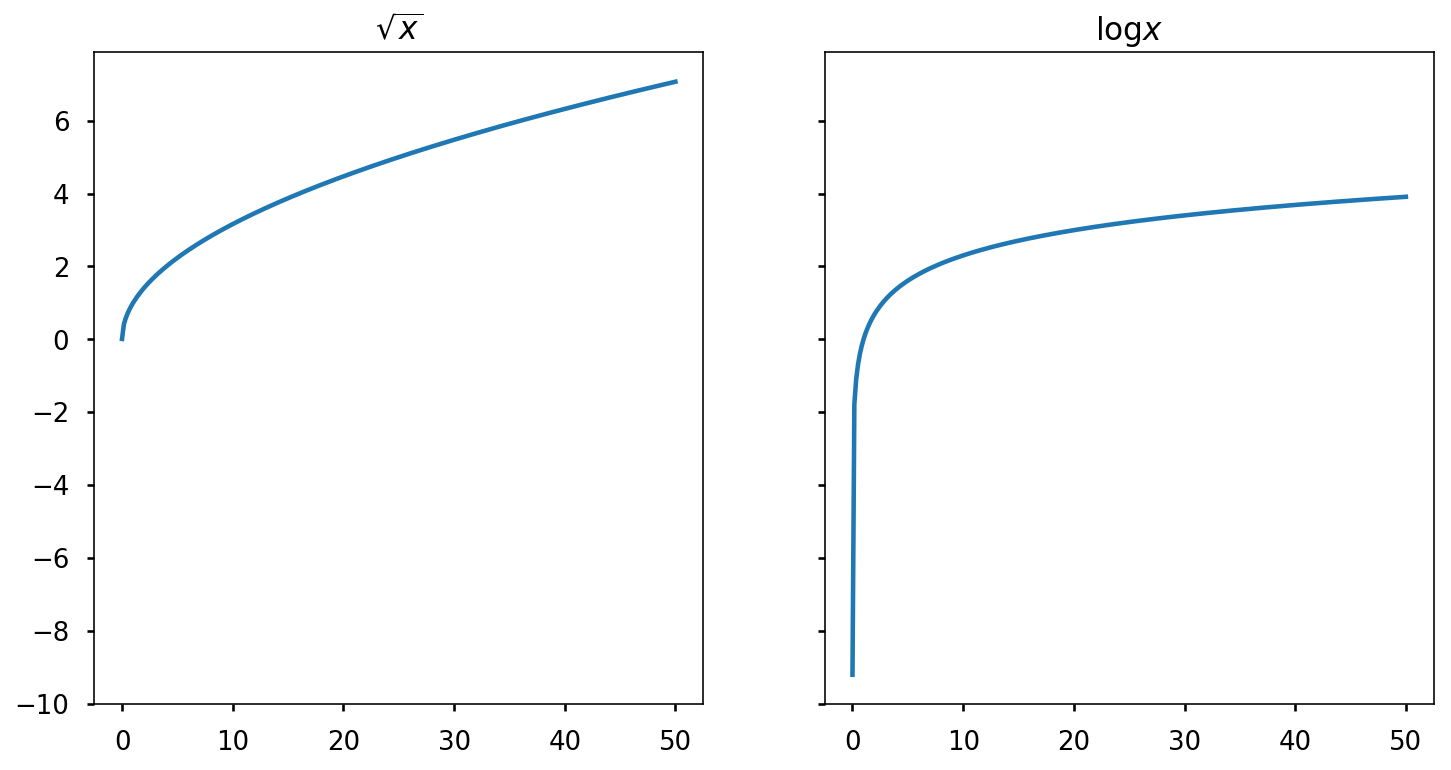

In [7]:
points = np.linspace(0.0001, 50, num=300)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title(r"$\sqrt{x}$"), ax2.set_title(r"$\log{x}$")
ax1.plot(points, np.sqrt(points))
ax2.plot(points, np.log(points));

### A different approach

Let's consider one more coin game.

> - Heads -> increase your wealth by 60%
> - Tails -> decrease your wealth by 50%

If your initial wealth is $x(0)$, then the expected value of one play is:  

$$\mathbb{E}(x(1)) = 0.5 \cdot 0.6 x(0) - 0.5 \cdot 0.4 x(0) = 0.1 x(0)$$

- Would you play this game?
- Once? Many times?


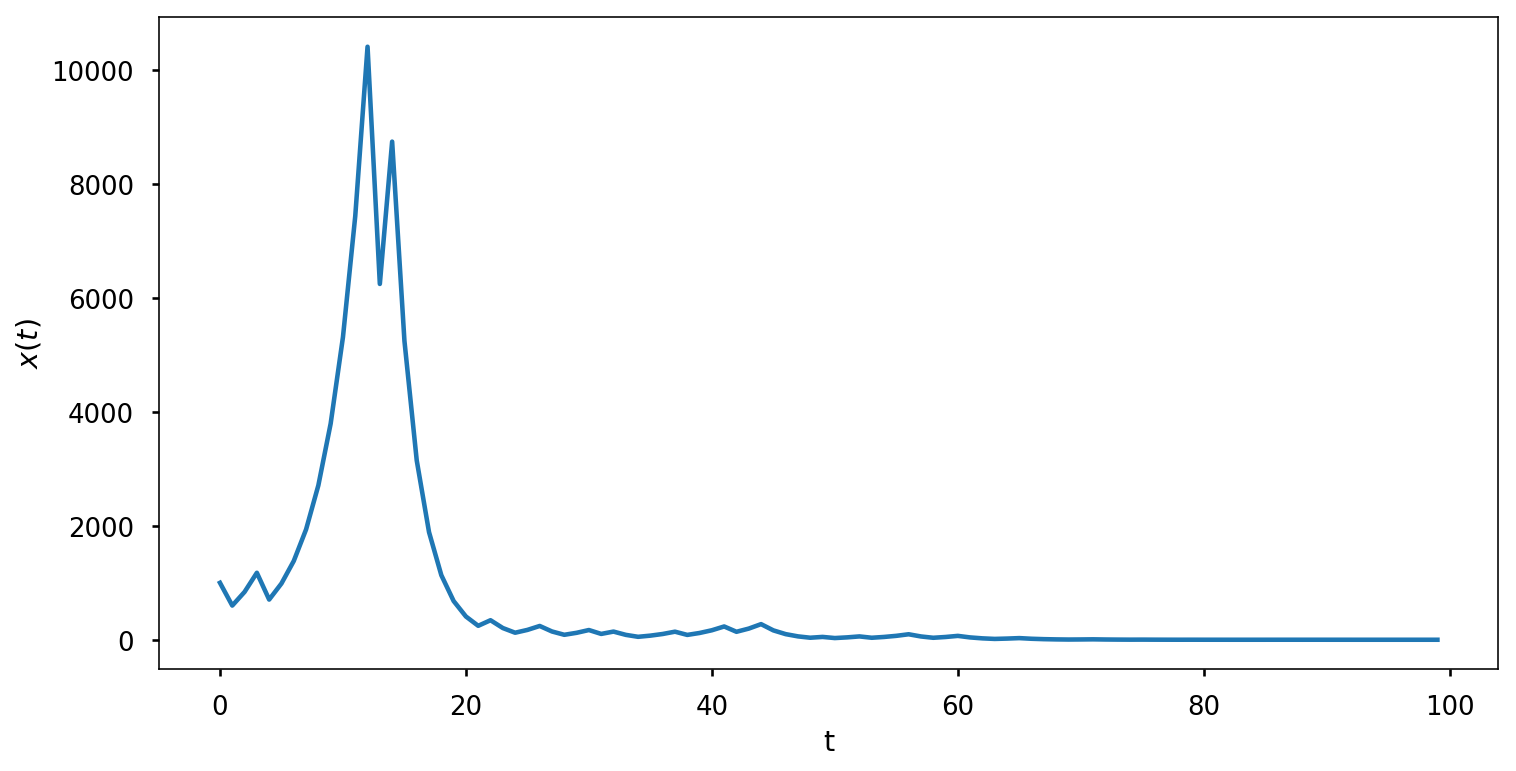

In [8]:
def play_game(initial_wealth, steps):
    draws = np.random.rand(steps)
    factors = np.where(draws > 0.5, 1.4, 0.6)
    factors[0] = 1 # Factor at initial time step
    return factors.cumprod() * initial_wealth

x_0 = 1_000
wealth = play_game(x_0, 100)
plt.plot(wealth)
plt.xlabel("t"), plt.ylabel(r"$x(t)$");

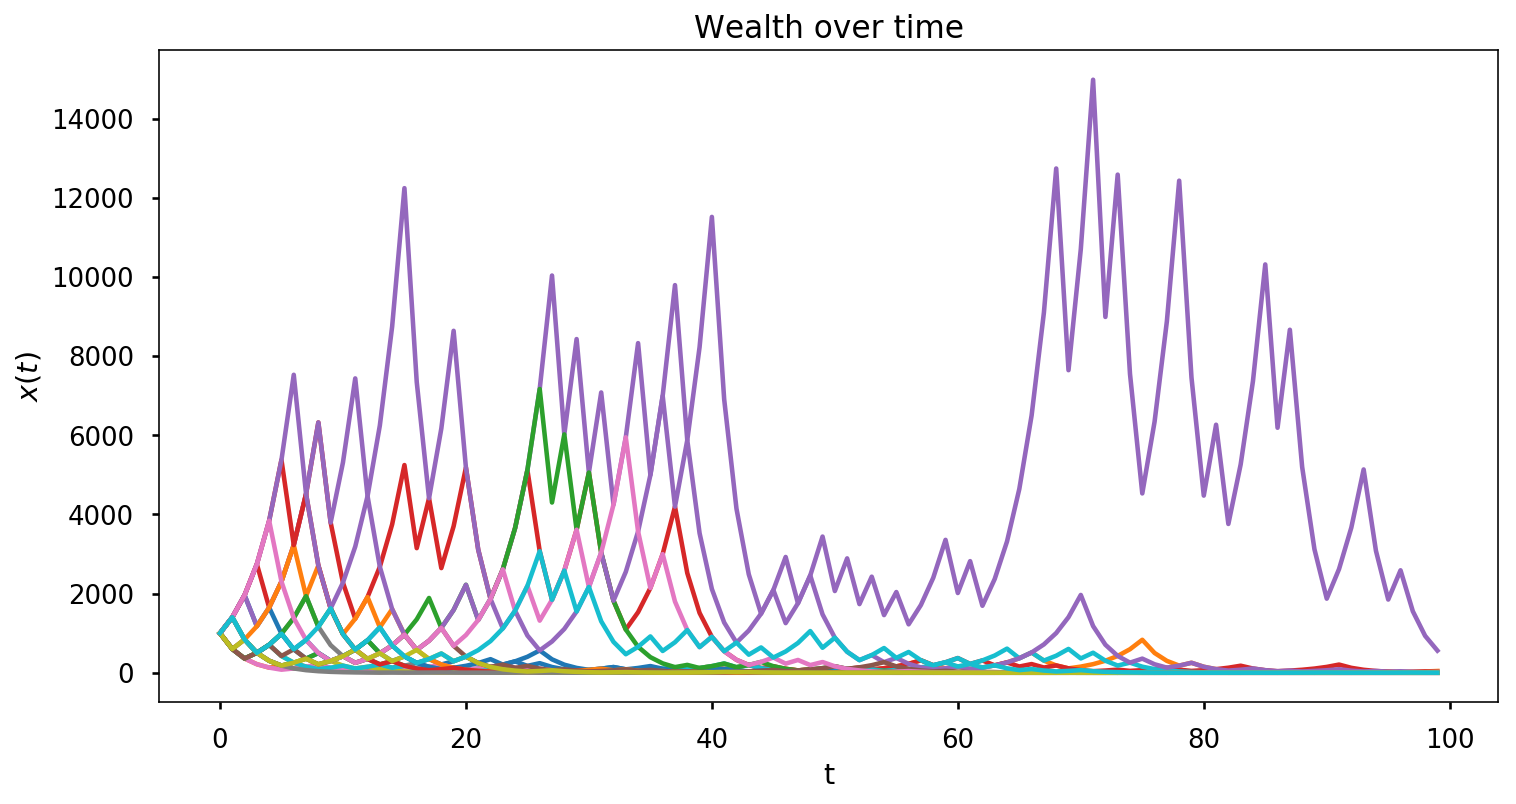

In [9]:
plays = [play_game(x_0, 100) for _ in range(20)]

for play in plays:
    plt.plot(play)

plt.title("Wealth over time")
plt.xlabel("t"), plt.ylabel(r"$x(t)$");

There is high variance in the short term, but over the long run we see that realizations tend to 0 as $t$ grows.
<br>
What is happening here is that as $t$ increases:

$$\lim_{t \to\infty} x(t) = 1.4^{t/2} 0.6^{t/2} = (1.4 \cdot 0.6)^{t/2} = 0.84^{t/2} = 0$$

We see that this game, which has a positive expected value, has a _time average_ value of 0.  
We say that such systems are **non ergodic**, that is, they behave differently when averaged over time as averaged over the space of all possible states.

## Optimal growth and gambler's ruin

Now suppose we could play a game infinitely many times where a coin is flipped, coming up heads with probability $p > 0.5$, tails with probalility $q = 1 - p$.  
You win an amount equal to your stake: if you bet $\$1$ you would earn $\$2$ if heads show up, $-\$1$ otherwise.

Let's set $p = 0.6$

In [10]:
def average_payout_biased_coin(n, p, stake):
    coin_flips = np.random.rand(n)
    payouts = np.where(coin_flips > p, -stake, 2*stake)
    
    return payouts.mean()

n = 1_000_000
p = 0.6
stake = 100

print(average_payout_biased_coin(n, p, stake))

79.9808


We're making money! Let's plot some more runs:

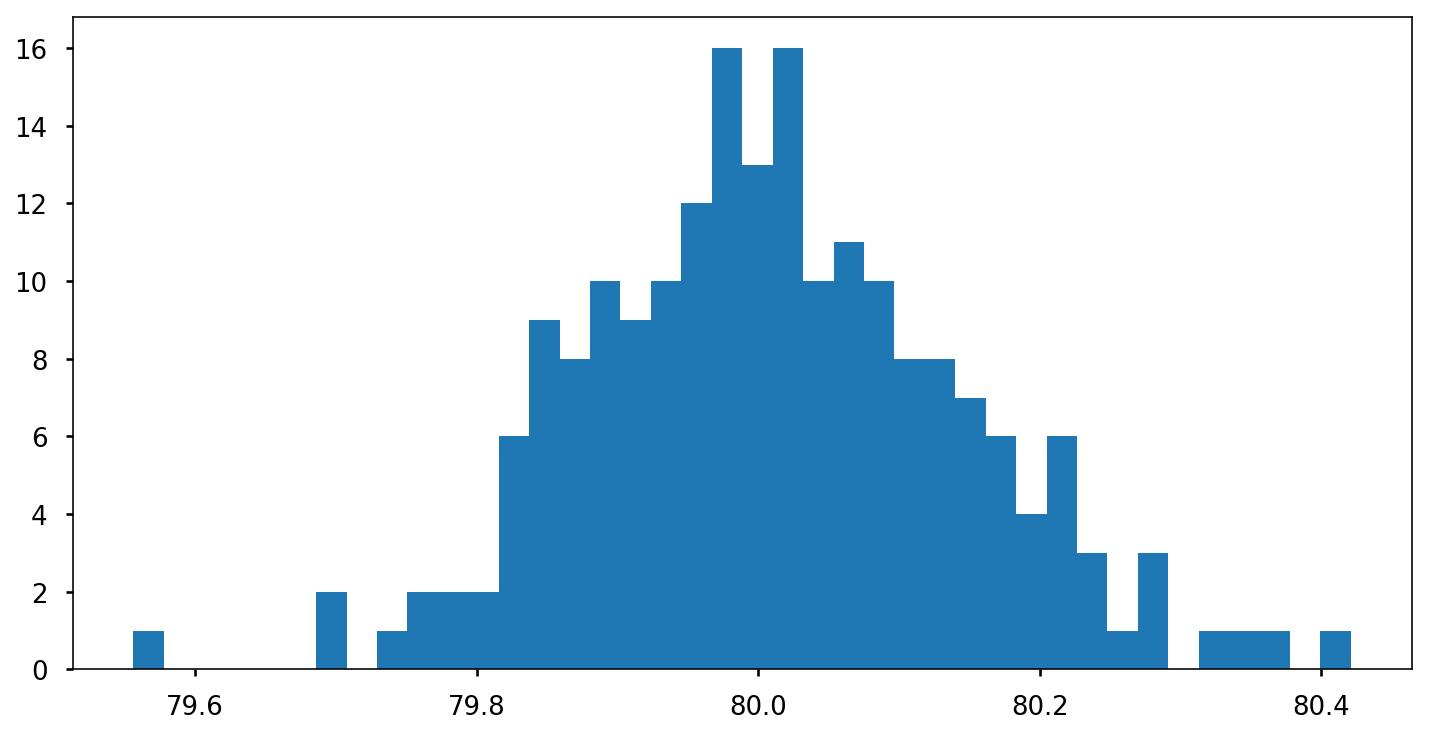

In [11]:
avg_payouts = [average_payout_biased_coin(x, p, stake) for x in np.full(200, n)]
plt.hist(avg_payouts, bins=40);

An interesting question:  

- How should we choose our stakes in order to maximise the rate at which our wealth grows?

Since the expected value of this game is positive, should we bet all our wealth each time? A fraction?

Given our initial wealth $x(0) = \$1000$, we have after $t$ plays:

In [12]:
def wealth_over_time(p, initial_wealth, t, stake):
    """Returns an np.array of wealth levels after `t` time steps.
    Arguments:
    p: float     - Probability of heads (win chance)
    x_0: float   - Initial wealth
    t: int       - Number of time steps
    stake: float - Fraction of wealth to bet
    """
    coin_flips = np.random.rand(t)
    factors = np.where(coin_flips > p, 1 - stake, 1 + stake)
    factors[0] = 1
    
    return factors.cumprod() * initial_wealth

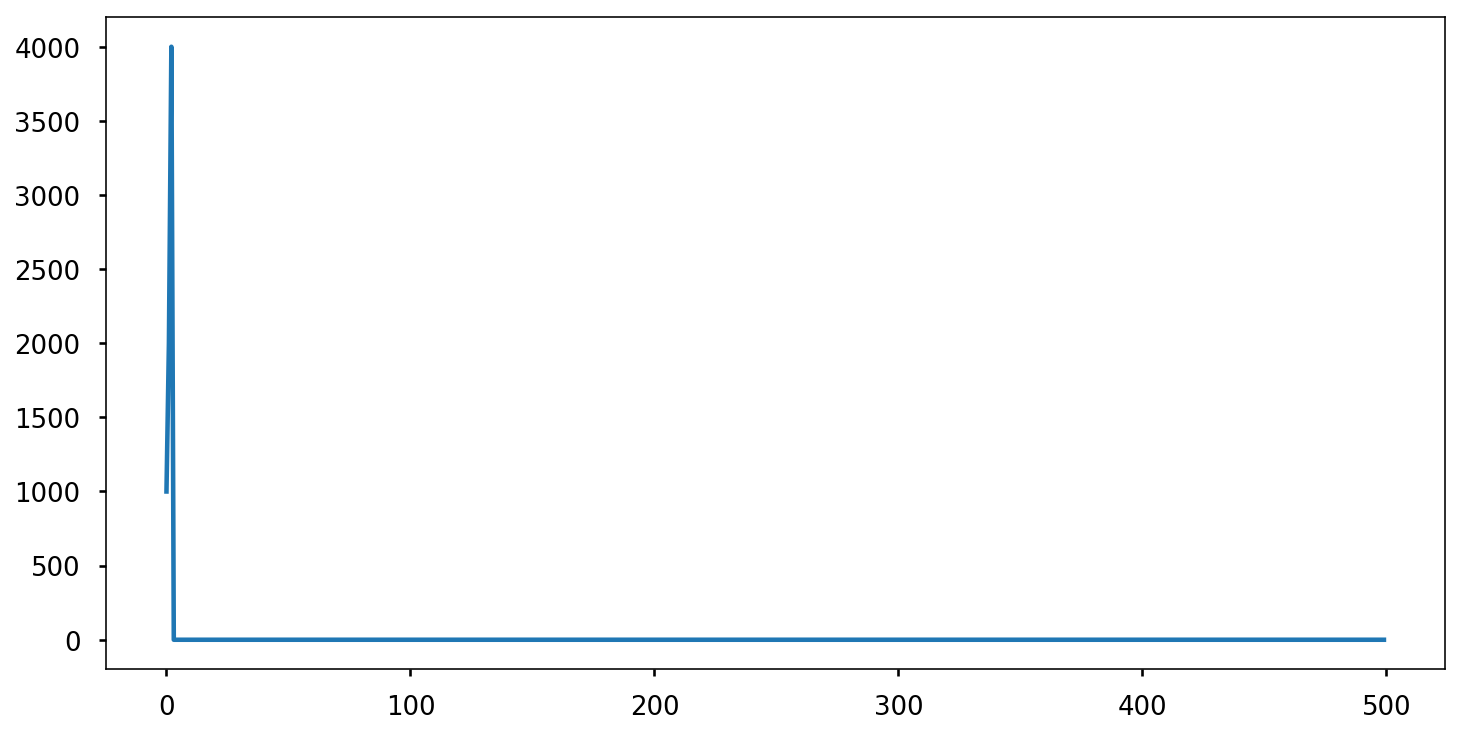

In [13]:
x_0 = 1_000

plt.plot(wealth_over_time(p, x_0, 500, 1.0));

If we try to maximise the rate of growth by betting all our wealth each time, we will inevitably go broke.  

Perhaps we should bet the minimum amount, and avoid bankrupcy.

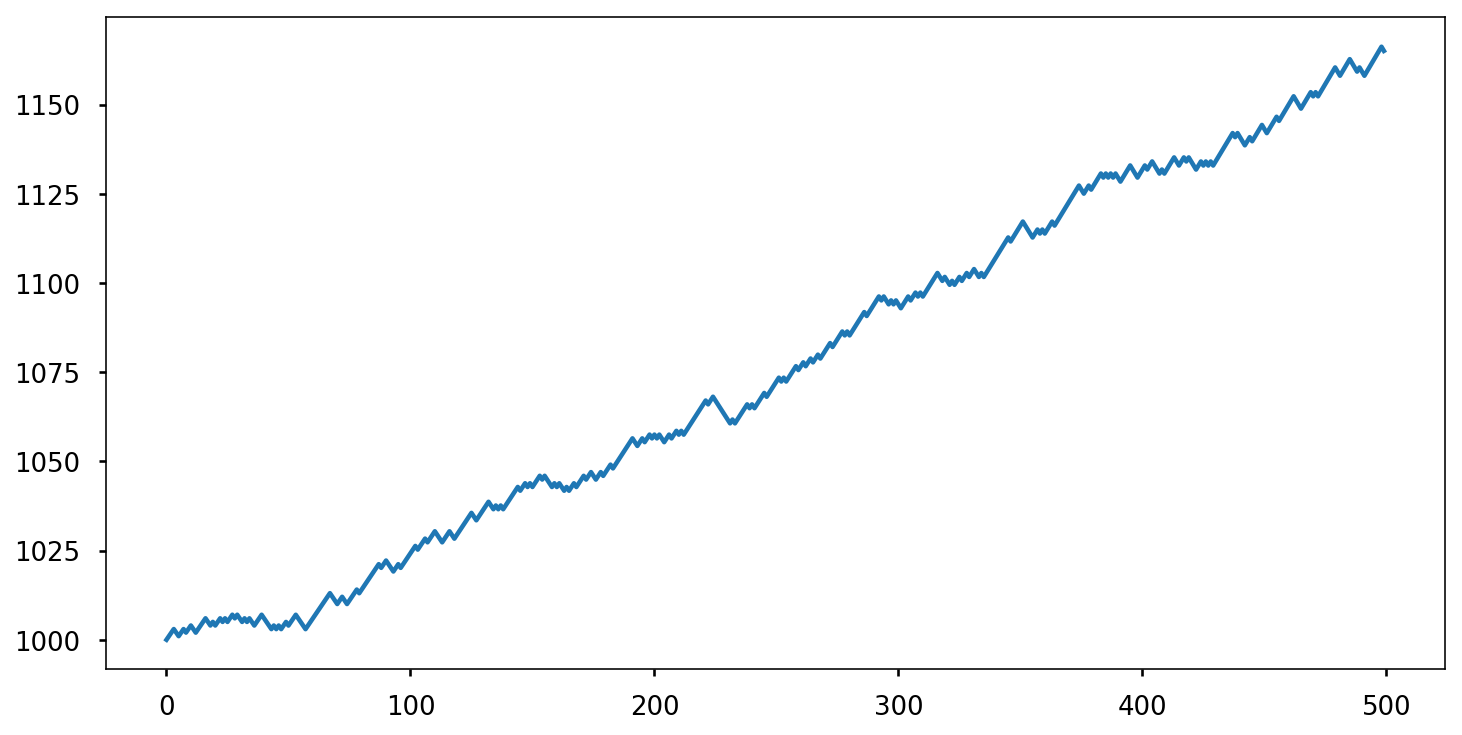

In [14]:
plt.plot(wealth_over_time(p, x_0, 500, 0.001));

We're not broke, but our earnings are growing timidly.   
Is there a better approach? 🤔

Let's look at how our wealth changes each time we play. We'll bet a fraction $f$ of our current wealth each time.  

$$x(t) = x(0)(1 + f)^\text{H}(1 - f)^\text{T}$$

Where $\text{H}$ is the number of times heads comes up, $\text{T}$ the number of tails.

The quantity $\frac{x(t)}{x(0)}$ can be rewritten as

$$\frac{x(t)}{x(0)} = e^{t \log{\left[ \frac{x(t)}{x(0)} \right]}^{\frac{1}{t}}}$$


Let's focus on this part:

$$G_{t}(f) = \log{\left[ \frac{x(t)}{x(0)} \right]}^{\frac{1}{t}} = \frac{H}{t}(1 + f) + \frac{T}{t}(1 - f)$$

We want to find $f^\ast$ that maximises  

$$g(f) = \mathbb{E} \Bigg \{ \frac{1}{t} \log{\left[ \frac{x(t)}{x(0)} \right]} \Bigg \}$$

🧙‍

$$g(f) = \mathbb{E} \Big \{ \frac{1}{t} \log{x(t)} - \frac{1}{t} \log{x(0)} \Big \}$$

Since $\frac{1}{t} \log{x(0)}$ is a constant, maximising $g(f)$ is the same as maximising $\mathbb{E} \Big \{ \frac{1}{t} \log{x(t)} \Big \}$

\begin{align}
g(f) & = \mathbb{E} \Big \{ \frac{H}{t} \log{(1 + f)} + \frac{T}{t} \log{(1 - f)} \Big \} \\
g(f) & = p \log{(1 + f)} + q \log{(1 - f)} \\
\end{align}

Let's plot $g(t)$

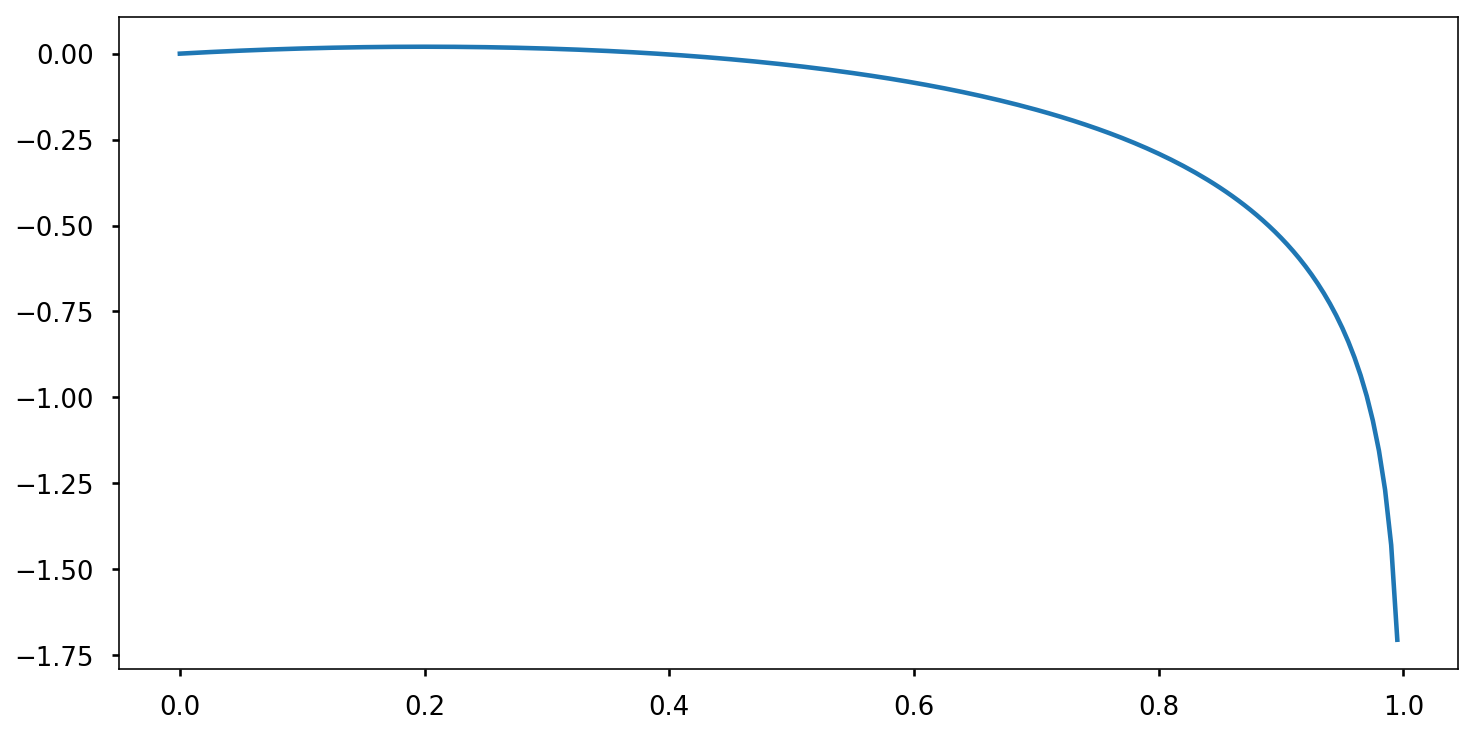

In [15]:
fs = np.linspace(0, 1, endpoint=False, num=200)
p, q = 0.6, 0.4
g_star = lambda f: p * np.log(1+f) + q * np.log(1-f)

plt.plot(fs, g_star(fs));

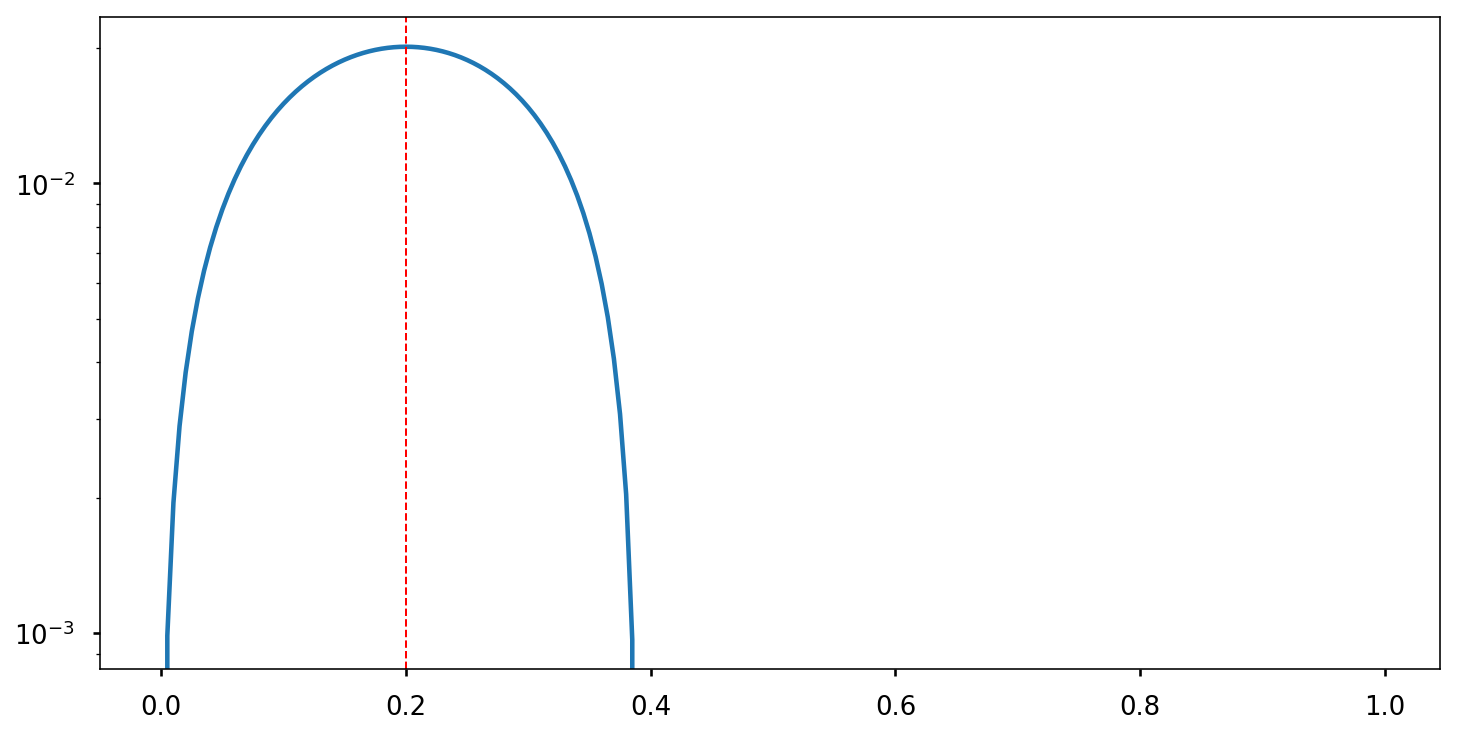

In [16]:
plt.plot(fs, g_star(fs))
plt.axvline(x=p-q, linestyle="--", color="r", linewidth=1)
plt.yscale("log");

We can calculate the maximum by taking the derivative.

\begin{align}
g^{\ast\prime} = \frac{p}{1+f} - \frac{q}{1+f} = \frac{p-q-f}{(1+f)(1-f)} = 0 \\
\end{align}

It follows then that $f^\ast = p - q$

This was first discovered by mathematician John Kelly in 1956. Known as _Kelly's criterion_ or _Kelly's formula_, it is used widely in gambling, finance and risk management.

Let's see how our wealth grows using Kelly's optimal betting strategy.

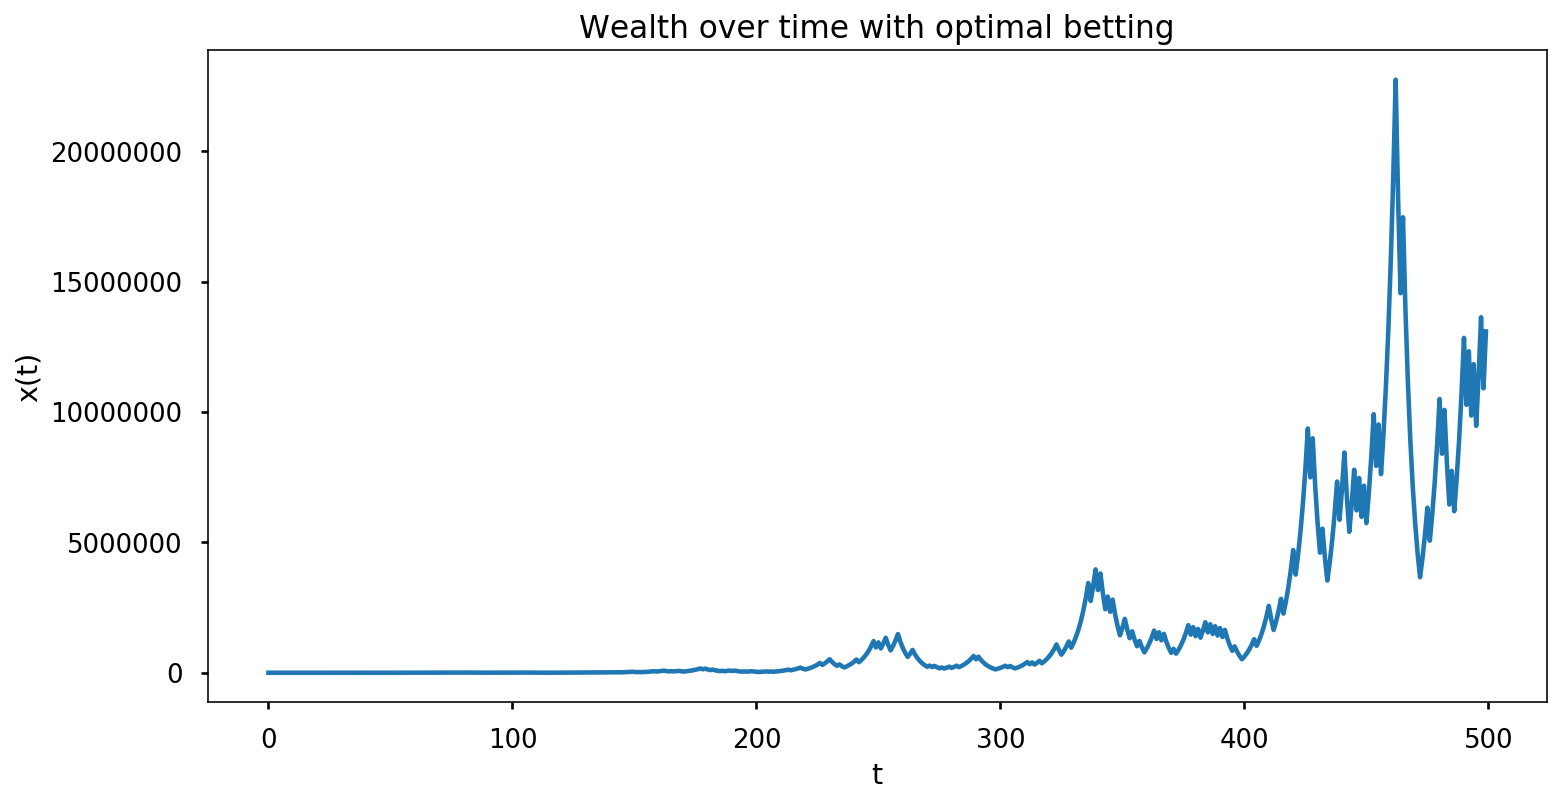

In [17]:
plt.title("Wealth over time with optimal betting")
plt.xlabel("t"), plt.ylabel("x(t)")
plt.ticklabel_format(style="plain")
wealth = wealth_over_time(p, x_0, 500, p-q)
plt.plot(wealth);

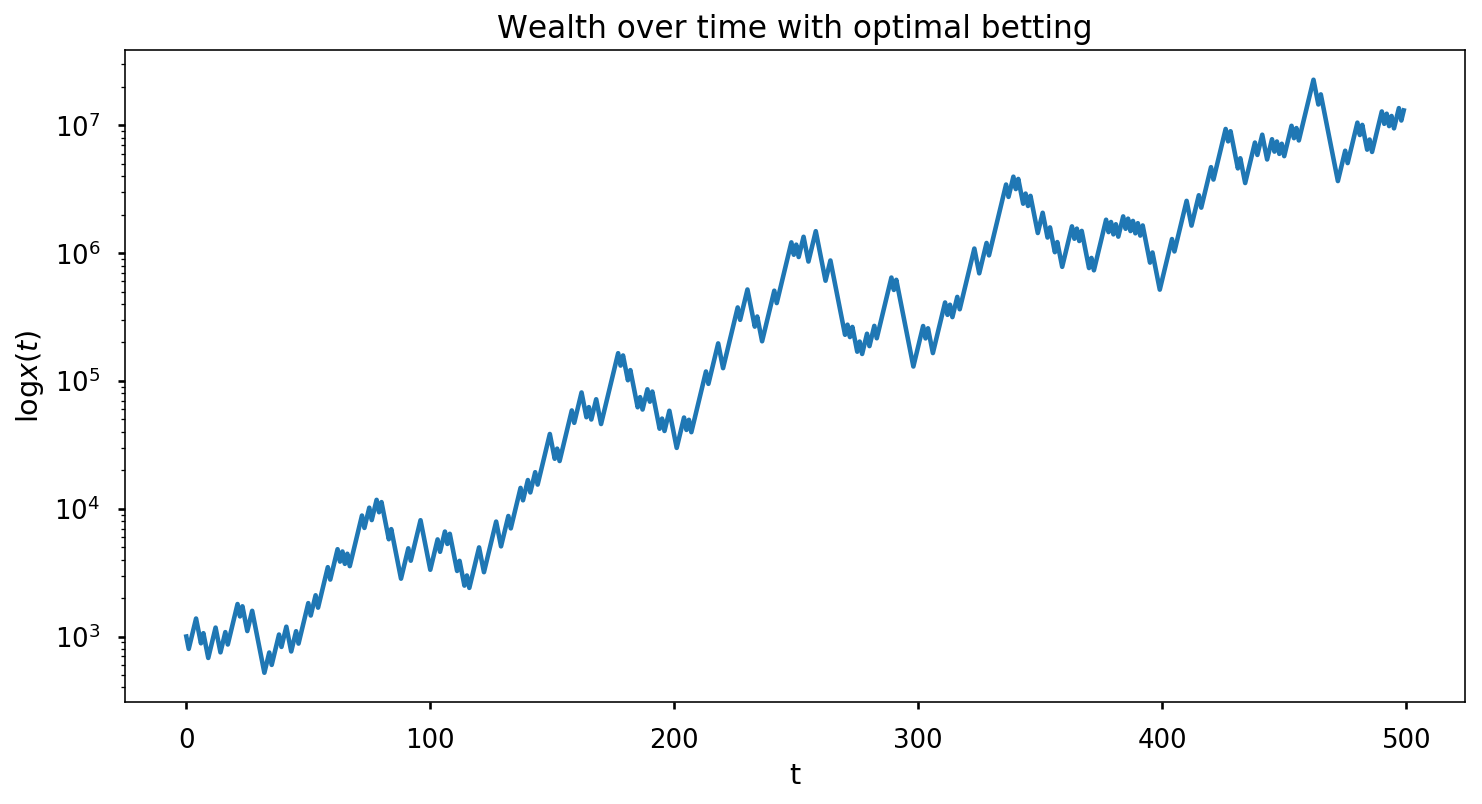

In [18]:
plt.title("Wealth over time with optimal betting")
plt.xlabel("t"), plt.ylabel(r"$\log{x(t)}$")
plt.yscale("log");
plt.plot(wealth);